<a href="https://colab.research.google.com/github/EduardMozharov/ML_Neural_networks/blob/main/Project_Emotion_Detection_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project "Emotion Detection"
##Этап 3: valence-arousal разложением эмоций


Итоговая работа курса SKILLBOX:  
Data Science. ML. Средний уровень (Нейронны сети))

# Задание
**Цель** - реализовать нейронную сеть, распознающую эмоции

**Задачи:**
1. Работа требует реализации алгоритма, с помощью которого будет происходить заданная классификация. Приветствуется использование архитектур свёрточных нейронных сетей, разобранных во время теоретических занятий. Время инференса сети на Google Colab не должно превышать 0,33 секунды (3 кадра в секунду).

2. Создать скрипт, который будет работать с их веб-камерами и выводить на экран текущую эмоцию.


**Дополнительно:**  
1. Используйте подходы по искусственному увеличению датасета для обучения, а именно — аргументации, рассмотренные в курсе.
2. Используйте продвинутые техники обучения, такие как finetuning и другие, рассмотренные в курсе.
3. Пишите структурный код (основная логика кода должна быть вынесена в классы/методы/функции + осмысленный нейминг сущностей и комментарии).
4. Проведите эксперименты с valence-arousal разложением эмоций, когда модель обучается не на самих эмоциях, а на их разложении по этим двум компонентам. Информация о подобном разложении есть в дополнительных материалах.

 
Работающий прототип из пункта «Улучшение и дополнения к заданию» прибавляет один балл к итоговой оценке и добавляет в портфолио ценный ML-проект.




## Отправка результата на проверку
Метрика данного соревнования categorisation accuracy.

Формат решения
Для каждого изображения в тестовом датасете, файл с решением должен содержать две колонки: image_path и emotion. image_path -- название изображение. Имеет формат k.jpg, где k натуральное число от 0 до 4999. emotion -- название предсказанной эмоции для данного изображение. Все представленные в задании эмоции вы можете найти на странице с описанием данных.

Итоговый csv файл должен иметь названия колонок и иметь структуру, как представлено ниже

image_path,emotion  
0.jpg,neutral  
1.jpg,angry  
2.jpg,sad  
3.jpg,contempt  

# 1 Загрузим необходимые библиотеки

In [ ]:
DO_IT = True # Выполнять ли особые части кода

In [ ]:
!pip install livelossplot

# Для работы оптимизатора TensorRT может потребоваться предыдущая версия tensorflow
#!pip install -U tensorflow==2.7.0
#!pip install keras==2.6.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
print('TensorFlow version:', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from livelossplot.tf_keras  import PlotLossesCallback

import timeit

TensorFlow version: 2.11.0


#2. Загрузим данные и рассмотрим их

## 2.1 Загрузим рисунки

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Один раз загрузим и разархивируем данные на личный диск,
# чтобы каждый раз заново не загружать данные
path_old = '/content/drive/MyDrive/SKILLBOX/FinalWorks/ML/'
path = '/content/'

!cp -a /content/drive/MyDrive/SKILLBOX/FinalWorks/ML/train.csv  /content/
!cp -a /content/drive/MyDrive/SKILLBOX/FinalWorks/ML/train/  /content/
!cp -a /content/drive/MyDrive/SKILLBOX/FinalWorks/ML/test_kaggle/  /content/

#os.chdir(path)
#!unzip -q train.zip
#!unzip -q test_kaggle.zip

## 2.2. Загрузим табличные данные и рассмотрим их

In [ ]:
# Загрузим таблицу с описанием данных train
df = pd.read_csv(path+'train.csv')
n_data = df.shape[0]
print('Количество строк данных', n_data)
df.head()

Количество строк данных 50046


,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [ ]:
emotions = df.emotion.unique()
n_emotions = emotions.shape[0]

print("Всего эмоций {}: {} ".format(n_emotions, emotions))

Всего эмоций 9: ['anger' 'contempt' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise'
 'uncertain'] 


**image_path** - строка, являющаюся путем до изображения в случае обучения или названием изображения в случае теста  
**emotion** - строка, характеризующая эмоцию  

  
В данном задании требуется предсказать 9 базовых эмоций, таких как:  
* **neutral** - нейтральная эмоция
* **anger**- гнев, злость
* **contempt** - презрение
* **disgust** - отвращение
* **fear** - страх
* **happy** - веселый
* **sad** - грусть
* **surprise** - удивленность
* **uncertain** - неуверенность

In [ ]:
df_count = df.groupby('emotion').count()['image_path']
df_count

emotion
anger        7022
contempt     3085
disgust      3155
fear         5044
happy        5955
neutral      6795
sad          6740
surprise     6323
uncertain    5927
Name: image_path, dtype: int64

## 2.3 Рассмотрим рисунки

In [ ]:
def show_img(img_ind=1):
  img = plt.imread(path+df['image_path'][img_ind][2:])
  plt.imshow(img)
  plt.title(df['emotion'][img_ind])

def show_random_test_img(n_img=10):
    plt.figure(figsize=(20,10))
    for i in range(n_img):
        plt.subplot(4,8, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_ind = random.randint(0, n_data)
        show_img(img_ind)

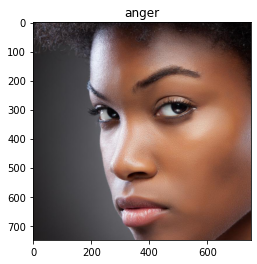

In [ ]:
if DO_IT: 
  show_img(1)

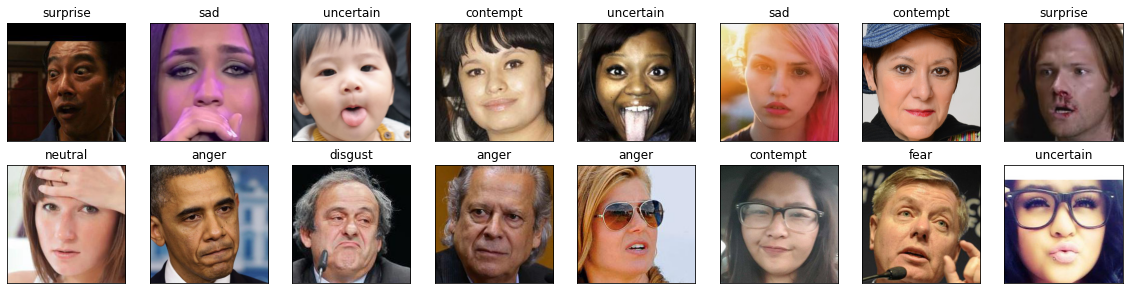

In [ ]:
if DO_IT:
  show_random_test_img(n_img=16)

# 3. Рассмотрим тестовые данные

In [ ]:
path_test = path + 'test_kaggle/'    # Путь к тестовым изображениям
path_test_new = path_test + '1/'  # Путь, куда переместим данные
 
'''
get_files = os.listdir(path_test)
for g in get_files:
  if g != '1':
    os.replace(path_test + g, path_test_new + g)
'''

"\nget_files = os.listdir(path_test)\nfor g in get_files:\n  if g != '1':\n    os.replace(path_test + g, path_test_new + g)\n"

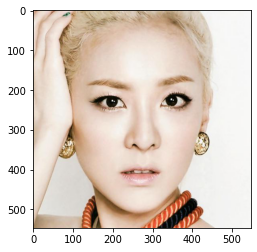

In [ ]:
def show_test_img(n_img=0):
  img = plt.imread(path_test_new + str(n_img) + '.jpg')
  plt.imshow(img)

if DO_IT:
  show_test_img(n_img=1)  

# 4. Применим valence-arousal

 Опираясь на источник https://habr.com/ru/company/speechpro/blog/418151/ применим разделение имеющихся эмоций на 2 составляющие: Arousal (интенсивность) и Valence (знак)


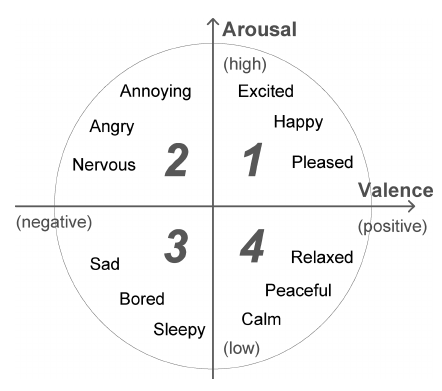

Для более четкого определения координат эмоций - возьмем следующий график
https://ru.pinterest.com/pin/734931232958332201/

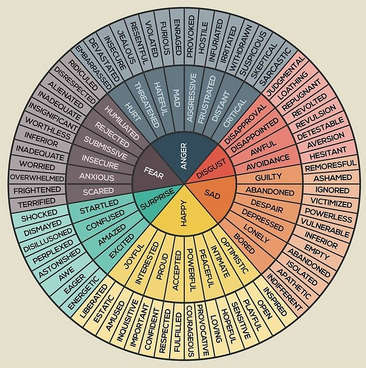

In [ ]:
# Добавим в DataFrame столбцы Arousal и Valence
# в соответсвии с эмоцией

# Словарь Эмоция -> Valence и Arousal
dict_em2AV = {'anger': (-1, 1),           # Злость
              'contempt': (-0.5, -0.25),  # Презрение
              'disgust': (-0.5, 0.25),    # Отвращение 
              'fear': (-0.5, 0.8),        # Страх
              'happy': (1, 0.5),          # Счастье
              'neutral': (0, 0),          # Нейтральный         
              'sad': (-0.25, -0.5),        # Грустный
              'surprise': (0, 1),         # Удивленный
              'uncertain': (-0.2, -1),    # Неуверенный
              }

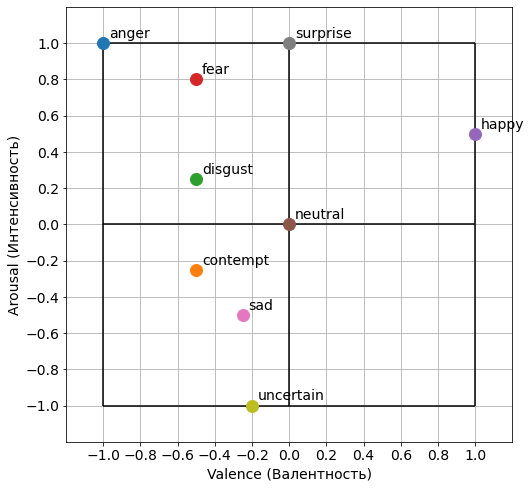

In [ ]:
# Построим мой график Arousal и Valence
fontsize = 14
lim = 1.2

plt.figure(figsize=(8,8))
plt.grid()
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])
plt.xticks(np.arange(-1,1.2,0.2), fontsize=fontsize)
plt.yticks(np.arange(-1,1.2,0.2), fontsize=fontsize)
for i in range(3):
  plt.hlines(i-1, -1, 1, 'k')
  plt.vlines(i-1, -1, 1, 'k')

for point in dict_em2AV:
  x = dict_em2AV[point][0]
  y = dict_em2AV[point][1]
  plt.plot(x, y, marker='o', markersize=12)
  plt.text(x+0.03, y+0.03, point, fontsize=fontsize)

plt.xlabel('Valence (Валентность)', fontsize=fontsize)
plt.ylabel('Arousal (Интенсивность)', fontsize=fontsize)

plt.show()

In [ ]:
# Добавим столбцы Arousal и Valence
df['Valence_and_Arousal'] = [dict_em2AV[emotion] for emotion in df['emotion']]
df['Valence'] = [dict_em2AV[emotion][0] for emotion in df['emotion']]
df['Arousal'] = [dict_em2AV[emotion][1] for emotion in df['emotion']]

df.head()

,Unnamed: 0,image_path,emotion,Valence_and_Arousal,Valence,Arousal
0,0,./train/anger/0.jpg,anger,"(-1, 1)",-1.0,1.0
1,1,./train/anger/1.jpg,anger,"(-1, 1)",-1.0,1.0
2,2,./train/anger/10.jpg,anger,"(-1, 1)",-1.0,1.0
3,3,./train/anger/100.jpg,anger,"(-1, 1)",-1.0,1.0
4,4,./train/anger/1000.jpg,anger,"(-1, 1)",-1.0,1.0


# 4. Подготовка данных. Аугментация.


In [ ]:
BATCH_SIZE = 512
IMG_SHAPE  = 64
VAL_PART = 0.2    # Размер валидационной выборки от исходных данных 
RANDOM_STATE = 17

## 4.1 Разобью выборку на обучающую и валидационную

In [ ]:
df['img_path_new'] = df['image_path'].apply(lambda x: x[2:])

In [ ]:
# Перемешаем случайным образом строки и выбирем 
df_train, df_val = np.split(df.sample(frac=1, random_state=RANDOM_STATE), [int((1-VAL_PART)*len(df))])

print('Размер обучающей выборки:', len(df_train))
print('Размер валидационной выборки:', len(df_val))

Размер обучающей выборки: 40036
Размер валидационной выборки: 10010


In [ ]:
# Проверим, что попали разные эмоции в каждую из выборок
print(df_train.groupby('emotion').count()['image_path'])
print('-------------------')
print(df_val.groupby('emotion').count()['image_path'])

emotion
anger        5627
contempt     2468
disgust      2562
fear         3940
happy        4745
neutral      5476
sad          5377
surprise     5064
uncertain    4777
Name: image_path, dtype: int64
-------------------
emotion
anger        1395
contempt      617
disgust       593
fear         1104
happy        1210
neutral      1319
sad          1363
surprise     1259
uncertain    1150
Name: image_path, dtype: int64


## 4.2 Выполним Аугментацию данных и создадим генераторы данных

In [ ]:
# Выполним Аугментацию
train_image_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20% 
      horizontal_flip=False, # случайное отражение по горизонтали
      vertical_flip=False, # случайное отражение по вертикали
      fill_mode="nearest", # чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
      #cval=0,
      ) 

val_image_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20% 
      horizontal_flip=False, # случайное отражение по горизонтали
      vertical_flip=False, # случайное отражение по вертикали
      fill_mode="nearest", # чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
      #cval=0,
      ) 

In [ ]:
%%time
# Создадим генератор на основе тренировочных данных
train_data_gen = train_image_generator.flow_from_dataframe(df_train, directory=path,
                                                           x_col='img_path_new', y_col=['Valence', 'Arousal'],
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='raw')

Found 40036 validated image filenames.
CPU times: user 195 ms, sys: 233 ms, total: 429 ms
Wall time: 461 ms


In [ ]:
# Создадим генератор на основе валидационных данных
val_data_gen = val_image_generator.flow_from_dataframe(df_val, directory=path,
                                                           x_col='img_path_new',  y_col=['Valence', 'Arousal'],
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='raw')

Found 10010 validated image filenames.


In [ ]:
def show_faces(images, labels, predicted_labels=None, emotions=emotions):
  # Демонстрирует изображения с подписями, и при наличии - их предсказаниями
    plt.figure(figsize=(20,10))
    for i in range(32):
        plt.subplot(4,8, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {emotions[labels[i]]}. Pred: {emotions[np.argmax(predicted_labels[i])]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {emotions[np.argmax(labels[i])]}")

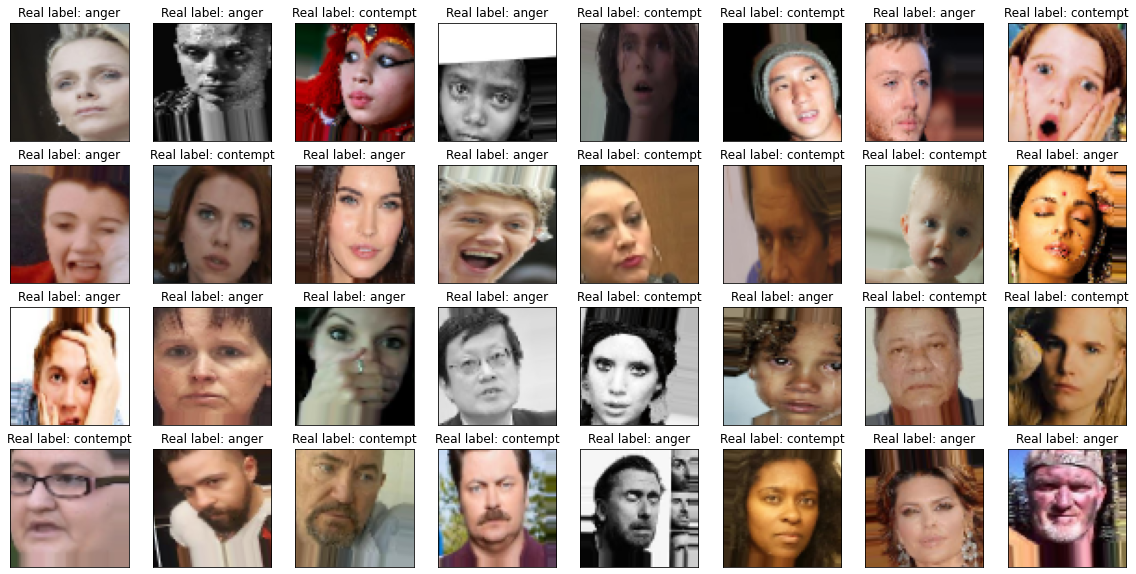

In [ ]:
#Посмотрим, что выдает генератор тренеровочных данных
if DO_IT:
  example_32_img = train_data_gen.next()[:32]
  show_faces(example_32_img[0], example_32_img[1], predicted_labels=None, emotions=emotions)

#5. Модель #1 - небольшая классическая сверточная нейронная сеть (CNN)

В ходе выполнения работы придерживаемся следующих правил по оптимизации времения выполнения сети:
1) Оптимизация модели при обучении:
   * 1.1)  От простой модели к сложной.
   * 1.2) Не заставлять учить то, что задается явно.
   * 1.3) Понизить ширину сети за счет Conv(1х1).
   * 1.4) Заменить Conv+Pool2D на Strided Conv.
   * 1.5) Использовать активацию Relu по возможности.
   * 1.6) Количество карт признаков делать кратным 8.
   * 1.7) Применить поканальную сепарабельную свертку (Depth-wise separable Conv).
   * 1.8) Применить Прореживание (Puring).
   * 1.9) Другое... 

2) Оптимизация модели после обучения: с помощью TensorRT

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['input_3[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 8, 8, 128)    73856       ['conv2d_7[0][0]']               
                                                                                            

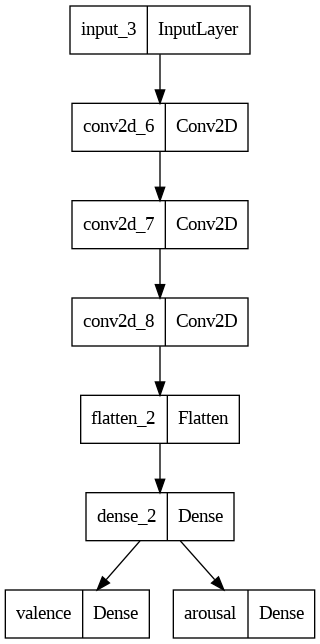

In [ ]:
input_layer = tf.keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))

output = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                 strides=(2,2))(input_layer)
output = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                 strides=(2,2))(output)
output = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                 strides=(2,2))(output)
output = tf.keras.layers.Flatten()(output)
bottleneck = tf.keras.layers.Dense(128, activation='relu')(output)

# Слои для определения Valence
valence_output = tf.keras.layers.Dense(1, name="valence", activation='tanh',
                                 use_bias=True)(bottleneck)

# Слои для определения Arousal
arousal_output = tf.keras.layers.Dense(1, name="arousal", activation='tanh',
                                       use_bias=True)(bottleneck)

# Формирование модели
outputs=[valence_output, arousal_output]
model_3 = tf.keras.Model(inputs=input_layer, outputs=outputs)

model_3.summary()
plot_model(model_3)

##5.1 Проверим время работы одного прохода нейронной сети

In [ ]:
%%timeit -n 10 -r 10
q_opt = model_3(np.random.rand(1, IMG_SHAPE, IMG_SHAPE, 3).astype(np.float32))

5.22 ms ± 964 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


## 5.2. Обучение модели

In [ ]:
# Скомпилируем модель
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss = {'valence': 'mse', 'arousal': 'mse'}
model_3.compile(optimizer=optimizer,
              loss=loss,
              metrics={'valence': 'mse', 'arousal': 'mse'})

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
             filepath= path + 'saved_models/model_3/model_3_checkpoint',
             monitor='loss', verbose=1, save_best_only=True,
             mode='min')

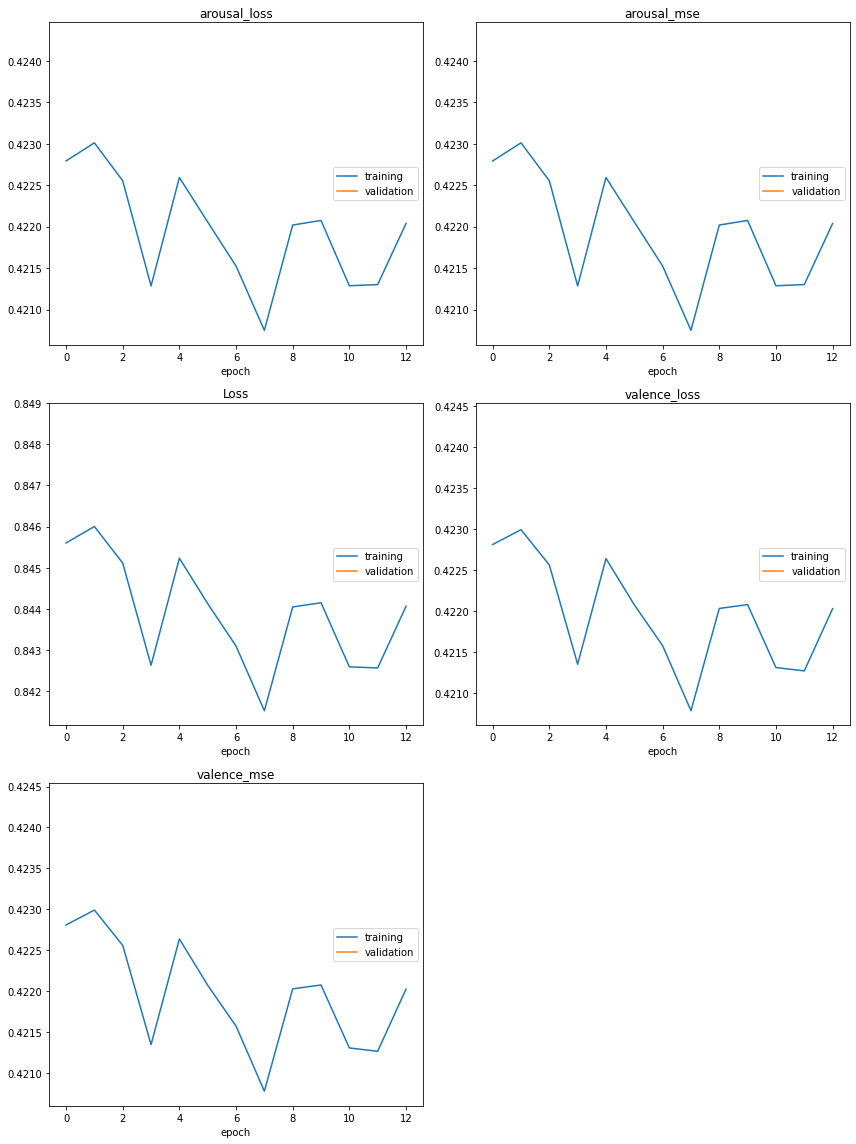

arousal_loss
	training         	 (min:    0.421, max:    0.423, cur:    0.422)
	validation       	 (min:    0.424, max:    0.424, cur:    0.424)
arousal_mse
	training         	 (min:    0.421, max:    0.423, cur:    0.422)
	validation       	 (min:    0.424, max:    0.424, cur:    0.424)
Loss
	training         	 (min:    0.842, max:    0.846, cur:    0.844)
	validation       	 (min:    0.849, max:    0.849, cur:    0.849)
valence_loss
	training         	 (min:    0.421, max:    0.423, cur:    0.422)
	validation       	 (min:    0.424, max:    0.424, cur:    0.424)
valence_mse
	training         	 (min:    0.421, max:    0.423, cur:    0.422)
	validation       	 (min:    0.424, max:    0.424, cur:    0.424)

Epoch 13: loss did not improve from 0.84153
64/64 [==============================] - 255s 4s/step - loss: 0.8441 - valence_loss: 0.4220 - arousal_loss: 0.4220 - valence_mse: 0.4220 - arousal_mse: 0.4220
Epoch 14/40
56/64 [=========================>....] - ETA: 33s - loss: 0.8421 - va

KeyboardInterrupt: ignored

In [ ]:
# Обучим модель
EPOCHS = 40
STEPS_PER_EPOCH = 64

history = model_3.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    steps_per_epoch = STEPS_PER_EPOCH,
#    validation_steps=1,
    shuffle = True,
    validation_freq=[0, 10, 20, 30, EPOCHS],
    callbacks=[PlotLossesCallback(), checkpoint]) # мы добавили коллбек для отрисовки прогресса

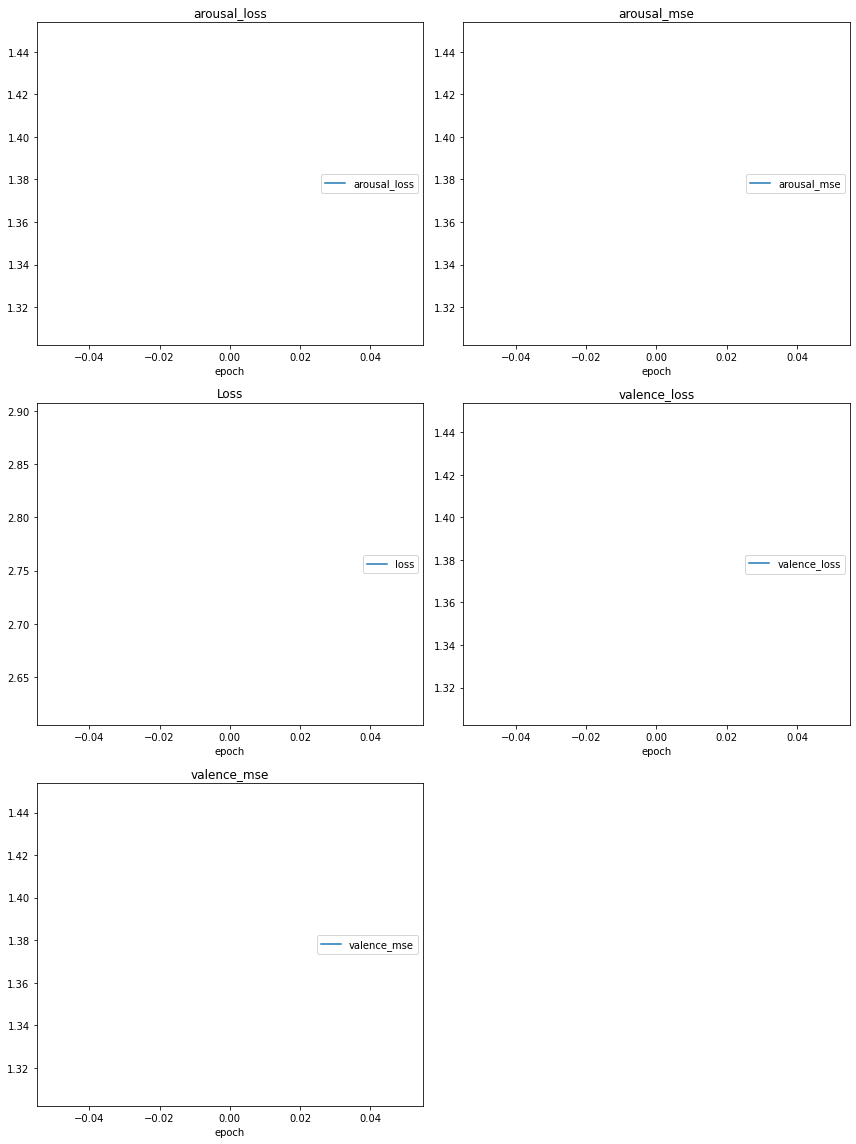

arousal_loss
	arousal_loss     	 (min:    1.378, max:    1.378, cur:    1.378)
arousal_mse
	arousal_mse      	 (min:    1.378, max:    1.378, cur:    1.378)
Loss
	loss             	 (min:    2.756, max:    2.756, cur:    2.756)
valence_loss
	valence_loss     	 (min:    1.378, max:    1.378, cur:    1.378)
valence_mse
	valence_mse      	 (min:    1.378, max:    1.378, cur:    1.378)

Epoch 1: loss improved from inf to 2.75602, saving model to /content/saved_models/model_3/model_3_checkpoint


64/64 [==============================] - 308s 5s/step - loss: 2.7560 - valence_loss: 1.3780 - arousal_loss: 1.3780 - valence_mse: 1.3780 - arousal_mse: 1.3780
Epoch 2/40
30/64 [=============>................] - ETA: 2:18 - loss: 2.7829 - valence_loss: 1.3915 - arousal_loss: 1.3915 - valence_mse: 1.3915 - arousal_mse: 1.3915

In [ ]:
# Обучим модель
EPOCHS = 40
STEPS_PER_EPOCH = 64

history = model_3.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    steps_per_epoch = STEPS_PER_EPOCH,
#    validation_steps=1,
    shuffle = True,
    validation_freq=[0, 10, 20, 30, EPOCHS],
    callbacks=[PlotLossesCallback(), checkpoint]) # мы добавили коллбек для отрисовки прогресса

##5.3 Сохраним модель

In [ ]:
def save_model_and_loss(model, history, path, name):
  '''
  Функция сохранения модели. И сохранения данных обучения в csv: 
  categorical_accuracy и  val_categorical_accuracy
  '''
  fullpath = path + name
  model.save(fullpath)
  # Сохраним историю
  df_losses = pd.DataFrame(history.history['loss'])
  df_losses.to_csv(fullpath + 'loss.csv')


In [ ]:
save_model_and_loss(model_3, history=history,
                       path=path_old+'saved_models/model_3/',
                       name='model_3_epochs_50')

In [ ]:
rt

#5.4 Загрузка модели

In [ ]:
model_3 = tf.keras.models.load_model(path_old + 'saved_models/model_3/model_3_epochs_10')

##5.5 Создадим функцию вычисления emotion from Valence и Arousal

In [ ]:
# Словарь Эмоция -> Valence и Arousal
dict_VA2em = { item: key for key, item in dict_em2AV.items() }
dict_VA2em

{(-1, 1): 'anger',
 (-0.5, -0.25): 'contempt',
 (-0.5, 0.25): 'disgust',
 (-0.5, 0.8): 'fear',
 (1, 0.5): 'happy',
 (0, 0): 'neutral',
 (-0.25, -0.5): 'sad',
 (0, 1): 'surprise',
 (-0.2, -1): 'uncertain'}

In [ ]:
def find_emotion_from_VA(pred, dict_VA2em):
  '''Function is convert VA coordinat to emotion
    pred - matrix with size(N, 2)
    dict_VA_2em - dictionary which keys - is coordinats AV of emotion
    VA - Valence и Arousal
  '''
  keys = [key for key in dict_VA2em] # Все координаты эмоций
  # Найдем номер эмоции к которой наиболее близко предсказание
  pred = np.array(pred)
  dist = np.array([np.linalg.norm(key - pred) for key in  keys])
  num_of_emotion = np.argmin(dist)
  emotion = dict_VA2em[keys[num_of_emotion]]
  return emotion

print('TEST')
print('------------------------------------------')
print(find_emotion_from_VA((-0.9, 1), dict_VA2em))
print(find_emotion_from_VA((0, 0.8), dict_VA2em))

anger


##5.6 Вычислим categorisation accuracy на валидационных данных

In [ ]:
pred_val = []
val = []

for val_i in val_data_gen.next():
  pred = model_3.test_step
  pred_val.append((pred[0], pred[0]))
  val.append(val_i[1])

pred_val

16/16 [==============================] - 0s 3ms/step


InvalidArgumentError: ignored

In [ ]:
val_data_gen.

array([[-0.5 , -0.25],
       [ 0.  ,  0.  ],
       [-0.25, -0.5 ],
       ...,
       [ 0.  ,  0.  ],
       [-0.25, -0.5 ],
       [ 0.  ,  0.  ]])

##5.5 Выполним предсказания на тестовых данных

In [ ]:
# Создадим генератор, выдающий преобразованные тестовые данные
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory=path_test,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False,
                                                         target_size=(IMG_SHAPE,IMG_SHAPE),
                                                         class_mode=None)

In [ ]:
# Функция генерирования csv файла с предсказаниями
def generate_prediction_csv(model, test_data_gen, name_of_file):
  ''' Функция генерирования csv файла с предсказаниями'''
  N = len(os.listdir(path_test_new))    # Количество тестовых рисунков
  filenames = test_data_gen.filenames   # Имена файлов генератора
  filenames = [filenames[i][2:] for i in range(N)]

  pred = model.predict(test_data_gen, batch_size=BATCH_SIZE) # Предсказания
  dict_pred = {'image_path':  filenames, 'emotion': emotions[np.argmax(pred, axis=1)]}    # Создаем словарь
  df = pd.DataFrame(data=dict_pred)
  # Отсортируем по порядку численному имена файлов
  df['num'] = [int(x[:-4]) for x in df['image_path']]
  df_pred = df.sort_values(by='num')[['image_path','emotion']]
  df_pred.to_csv(name_of_file + '.csv', sep=',', index=False)
  return df_pred

In [ ]:
# Другой способ реализации Функции генерирования csv файла с предсказаниями
'''
def generate_prediction_csv(model, path_test, IMG_SHAPE, name_of_file):
  # Функция генерирования csv файла с предсказаниями
  N = len(os.listdir(path_test_new))
  pred = {}
  for i in range(N):
    name = str(i) + '.jpg'
    img = plt.imread(path_test + name)
    img_mod = tf.image.resize(img, (IMG_SHAPE, IMG_SHAPE), tf.image.ResizeMethod.BILINEAR)
    img_mod =  img_mod * 1./255
    pred[name] = model.predict(img_mod[..., ::-1])

  df_pred = pd.DataFrame(pred,columns=['image_path', 'emotion'])
  df_pred.to_csv(name_of_file + '.csv', sep=',')
  return df_pred
'''

# Третий способ - создать датафрейм и создать генератор по нему через .flow_from_dataframe

In [ ]:
# Генерирую файл csv с предсказанием
%%time
df_pred = generate_prediction_csv(model_1, test_data_gen, path+'prediction_model_1_epochs_120')
df_pred.head()

| IMG_SHAPE     | BATCH_SIZE  | EPOHS| Time, hours |   categorical_accuracy  | 
| ------------- |-------------|-----| ----------------------| ----------------------|
|  64           | 128       | 30  | 4 |0.2356| 
|  64           | 128       | 40  | 5 |0.2532| 
|  64           | 128       | 60  | 6 |0.3017| 
|  64           | 128       | 80  | 7 |0.3406| 
|  64           | 256       | 60  |  |0.| 